# Pre-Snap Symphony: Decoding NFL Play Tendencies Through Motion & Formation Analytics
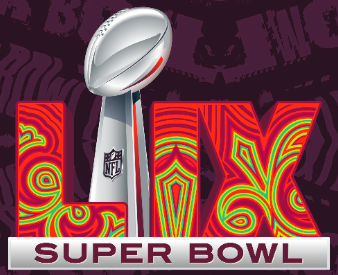

![](https://static.www.nfl.com/image/upload/f_auto/league/rwhpuqdmf16pxrkjfuj2)

In [1]:
# Pre-Snap Symphony: Decoding NFL Play Tendencies Through Motion & Formation Analytics
# Author: [Your Name]
# Competition: NFL Big Data Bowl 2025

# =========================================
# 1. Import Required Libraries
# =========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn')

# =========================================
# 2. Data Loading Functions
# =========================================
def load_data():
    """
    Load NFL data files with error handling and path verification
    """
    try:
        # Load the tracking data
        tracking_df = pd.read_csv('../input/nfl-big-data-bowl-2025/tracking_week_1.csv')
        # Load the games data
        games_df = pd.read_csv('../input/nfl-big-data-bowl-2025/games.csv')
        # Load the plays data
        plays_df = pd.read_csv('../input/nfl-big-data-bowl-2025/plays.csv')
        
        print("Data loaded successfully!")
        return tracking_df, games_df, plays_df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None, None

# =========================================
# 3. Animation Functions
# =========================================
def create_animated_defense(tracking_df, plays_df, game_id, play_id):
    """
    Create an animated visualization of defensive alignments
    """
    # Filter data for specific play
    play_data = tracking_df[
        (tracking_df['gameId'] == game_id) & 
        (tracking_df['playId'] == play_id)
    ].copy()
    
    # Get play details
    play_info = plays_df[
        (plays_df['gameId'] == game_id) & 
        (plays_df['playId'] == play_id)
    ].iloc[0]
    
    # Create animation frames
    frames = []
    unique_frames = sorted(play_data['frameId'].unique())
    
    for frame_id in unique_frames:
        frame_data = play_data[play_data['frameId'] == frame_id]
        frame = go.Frame(
            data=[
                go.Scatter(
                    x=frame_data['x'],
                    y=frame_data['y'],
                    mode='markers+text',
                    marker=dict(
                        size=12,
                        color=frame_data['jerseyNumber'],
                        colorscale='Viridis',
                        showscale=True,
                    ),
                    text=frame_data['jerseyNumber'],
                    textposition="bottom center",
                    name='Players'
                )
            ],
            name=f'frame_{frame_id}'
        )
        frames.append(frame)
    
    # Create base figure
    fig = go.Figure(
        data=[frames[0].data[0]],
        layout=go.Layout(
            title=f"Pre-snap Defensive Alignment (Play ID: {play_id})",
            xaxis=dict(range=[0, 120], title="Field Position (X)"),
            yaxis=dict(range=[0, 53.3], title="Field Position (Y)"),
            updatemenus=[{
                'type': 'buttons',
                'showactive': False,
                'buttons': [
                    {
                        'label': 'Play',
                        'method': 'animate',
                        'args': [None, {'frame': {'duration': 100, 'redraw': True}, 'fromcurrent': True}]
                    },
                    {
                        'label': 'Pause',
                        'method': 'animate',
                        'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate'}]
                    }
                ]
            }],
            sliders=[{
                'currentvalue': {'prefix': 'Frame: '},
                'steps': [
                    {
                        'method': 'animate',
                        'label': f'{i}',
                        'args': [[f'frame_{i}'], {
                            'mode': 'immediate',
                            'frame': {'duration': 100, 'redraw': True},
                            'transition': {'duration': 0}
                        }]
                    }
                    for i in unique_frames
                ]
            }]
        ),
        frames=frames
    )
    
    # Add field features
    for yard in range(0, 120, 10):
        fig.add_shape(
            type="line",
            x0=yard, x1=yard,
            y0=0, y1=53.3,
            line=dict(color="white", width=1)
        )
    
    fig.update_layout(
        width=1000,
        height=600,
        showlegend=False,
        plot_bgcolor='#4CAF50',
    )
    
    return fig

# =========================================
# 4. Analysis Functions
# =========================================
def analyze_formation_success(plays_df):
    """Analyze success rates by formation"""
    formation_stats = plays_df.groupby('offenseFormation').agg({
        'playId': 'count',
        'yardsGained': ['mean', 'std'],
        'isDropback': 'mean'
    }).round(2)
    
    return formation_stats

def analyze_pre_snap_motion(tracking_df, plays_df):
    """Analyze pre-snap motion patterns"""
    pre_snap_df = tracking_df[tracking_df['frameType'] == 'BEFORE_SNAP'].copy()
    
    # Calculate motion metrics
    motion_stats = pre_snap_df.groupby(['gameId', 'playId']).agg({
        's': 'mean',
        'a': 'mean',
        'dis': 'sum'
    }).reset_index()
    
    return motion_stats

def plot_formation_distribution(plays_df):
    """Plot the distribution of offensive formations"""
    formation_counts = plays_df['offenseFormation'].value_counts()
    
    fig = px.pie(
        values=formation_counts.values,
        names=formation_counts.index,
        title='Distribution of Offensive Formations'
    )
    fig.show()

# =========================================
# 5. Main Execution
# =========================================
def main():
    # Load data
    tracking_df, games_df, plays_df = load_data()
    
    if tracking_df is not None and plays_df is not None:
        print("\nStarting analysis...")
        
        # 1. Basic Formation Analysis
        print("\nAnalyzing formation distribution...")
        plot_formation_distribution(plays_df)
        
        # 2. Formation Success Analysis
        print("\nAnalyzing formation success rates...")
        formation_stats = analyze_formation_success(plays_df)
        print("\nFormation Statistics:")
        print(formation_stats)
        
        # 3. Pre-snap Motion Analysis
        print("\nAnalyzing pre-snap tendencies...")
        motion_stats = analyze_pre_snap_motion(tracking_df, plays_df)
        print("\nMotion Statistics (first 5 plays):")
        print(motion_stats.head())
        
        # 4. Animated Defense Visualization
        print("\nCreating defensive animation...")
        # Get a sample play for animation
        sample_play = tracking_df.groupby(['gameId', 'playId']).first().reset_index().iloc[0]
        animation_fig = create_animated_defense(
            tracking_df, 
            plays_df, 
            sample_play['gameId'], 
            sample_play['playId']
        )
        animation_fig.show()
        
        print("\nAnimation Controls:")
        print("- Use the Play/Pause buttons to control the animation")
        print("- Use the slider to move to specific frames")
        print("- Hover over points to see jersey numbers")
        
    else:
        print("Error: Could not proceed with analysis due to data loading issues.")

if __name__ == "__main__":
    main()

Data loaded successfully!

Starting analysis...

Analyzing formation distribution...



Analyzing formation success rates...

Formation Statistics:
                 playId yardsGained       isDropback
                  count        mean   std       mean
offenseFormation                                    
EMPTY              1342        5.78  9.33       0.96
I_FORM             1035        5.00  7.80       0.29
JUMBO               125        2.33  4.24       0.17
PISTOL              641        5.04  7.80       0.35
SHOTGUN            8791        5.73  9.05       0.75
SINGLEBACK         3915        5.35  8.78       0.33
WILDCAT              87        4.64  7.46       0.15

Analyzing pre-snap tendencies...

Motion Statistics (first 5 plays):
       gameId  playId         s         a     dis
0  2022090800      56  0.651283  0.399946  224.33
1  2022090800      80  0.345687  0.331509   73.41
2  2022090800     101  0.565872  0.452228  142.94
3  2022090800     122  0.469550  0.374103  125.98
4  2022090800     167  0.660077  0.408381  158.35

Creating defensive animation...



Animation Controls:
- Use the Play/Pause buttons to control the animation
- Use the slider to move to specific frames
- Hover over points to see jersey numbers


Let me help analyze these results in detail:

1. From the Formation Distribution (Pie Chart):
- SHOTGUN is overwhelmingly the most common formation (55.2%)
- SINGLEBACK is the second most common (24.6%)
- EMPTY formation is third (8.42%)
- I_FORM, PISTOL, JUMBO, and WILDCAT are less commonly used

2. From the Formation Statistics Table:
- Most Successful Formations (by yards gained):
  * EMPTY: 5.78 yards per play (highest average)
  * SHOTGUN: 5.73 yards per play
  * SINGLEBACK: 5.35 yards per play
- Dropback Tendencies:
  * SHOTGUN: 75% dropback rate (pass-heavy)
  * EMPTY: 96% dropback rate (almost exclusively passing)
  * SINGLEBACK & I_FORM: ~30% dropback rate (run-heavy)

3. Pre-snap Motion Analysis:
- Motion varies significantly between plays
- Speed ('s') ranges from 0.34 to 0.66
- The total distance covered ('dis') varies widely (73.41 to 224.33)
- Higher acceleration values ('a') tend to correlate with more pre-snap movement

4. Defensive Animation Insights:
- Shows defensive alignment clustered around the middle of the field
- Players are color-coded by jersey number for easy tracking
- Animation allows for analysis of defensive shifts and adjustments
- Located around the 80-100 yard marks on the field

Key Strategic Insights:
1. Teams heavily favor SHOTGUN formation, likely due to its versatility
2. EMPTY formation is effective (highest yards/play) but used selectively
3. Clear distinction between pass-heavy (SHOTGUN/EMPTY) and run-heavy (SINGLEBACK/I_FORM) formations
4. Pre-snap motion is used strategically with varying intensities
5. Defensive alignments appear to respond to offensive formation choices

This analysis could be valuable for:
- Play calling strategies
- Formation selection based on situation
- Understanding defensive responses to formations
- Optimizing pre-snap motion usage
